In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from CRIS import data
from CRIS import classify
from CRIS import regress



files = ["CRIS/BH_data/data_-2.500.dat", \
         "CRIS/BH_data/data_-2.625.dat",
         "CRIS/BH_data/data_-2.750.dat"]

input_cols = ['log10(M_1i)(Msun)', 'P_i(days)', 'metallicity' ]

output_cols = ['result', 'had_contact', 'M_1f(Msun)', 'M_2f(Msun)', 'P_f(days)', 
               'merge_time(Gyr)', 'Kerr_param_1', 'Kerr_param_2', 
               'he_core_mass_1', 'c_core_mass_1', 'total_mass_h1_1', 
               'total_mass_he4_1', 'he_core_mass_2', 'c_core_mass_2', 
               'total_mass_h1_2', 'total_mass_he4_2']

class_col = 'result' # single colum where we want to id different classes

table_object = data.TableData( files, input_cols, output_cols, 
                               class_col, ignore_lines = 15 )






"""
Takes the data and regressor, returns average relative percent error of regressor
"""
def old_analytical(inp, puredata, regressor):
    #regressor.get_predictions(["rbf"], ["PISN"], ["merge_time(Gyr)"], inp)
    predicted_values = regressor._predict("rbf", "PISN", "merge_time(Gyr)", inp)
    diffs = predicted_values - puredata
    
    where_zero = np.where( puredata == 0 )[0] # 1d array
    where_not_zero = np.where( puredata != 0 )[0] # 1d array
    
    if len(where_zero) > 0:
        percent_diffs = (diffs[where_not_zero] / puredata[where_not_zero])
        #print("%i output with value zero. Omitting for percent change calculation."%(len(where_zero)))
    else:
        percent_diffs = (diffs / puredata)
    
    return np.average(percent_diffs)

def analytical(regressor, regresion, classification, column):
    old_pre = baseline_reg._predict(regresion, classification, column, table_object.get_regr_input_data()[classification].to_numpy(float))
    new_pre = regressor._predict(regresion, classification, column, table_object.get_regr_input_data()[classification].to_numpy(float))
    pure_data = table_object.get_regr_sorted_output_data()[classification][column].to_numpy(float)
    
    old_diffs = new_pre - pure_data
    old_percent_diffs = old_diffs[np.where(pure_data != 0)[0]] / old_pre[np.where(pure_data != 0)[0]]
    new_diffs = old_pre - pure_data
    new_percent_diffs = new_diffs[np.where(pure_data != 0)[0]] / old_pre[np.where(pure_data != 0)[0]]

    return np.average(abs(old_percent_diffs))-np.average(abs(new_percent_diffs))


baseline_reg = regress.Regressor(table_object)
baseline_reg.train("GaussianProcessRegressor", ["PISN"], ["merge_time(Gyr)"],
                   verbose = False, di = np.arange(0, 915, 5))

"""
A value function
"""
def value_func(new_points):
    #print(new_points)
    return reg_value_func(new_points, "GaussianProcessRegressor", "PISN", "merge_time(Gyr)")

def reg_value_func(new_points, regresion, classification, column):
    points = np.unique(np.concatenate((np.arange(0, 915, 5), new_points)).astype(int))
    new_reg = regress.Regressor(table_object)
    new_reg.train(regresion, [classification], [column], verbose = False, di = points)
    return analytical(new_reg, regresion, classification, column)

value_func(np.random.choice(np.arange(0, 915), size=100).astype(int))

Reading in data from 3 file(s).
CRIS/BH_data/data_-2.500.dat
CRIS/BH_data/data_-2.625.dat
CRIS/BH_data/data_-2.750.dat
Finished reading data.

Total number of data points: 23055

Input columns: 3
Output columns: 16
Unique classes found in result: 6

Finding values to regress:

Num output(s) 	 Class Name
      1 	 'L2_overflow'
     15 	 'PISN'
      1 	 'ZAMS_L2_overflow'
      0 	 'convergence_error'
     15 	 'double_BH'
      0 	 'off_CHE'


-0.026150086916678875

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from CRIS import data
from CRIS import classify
from CRIS import regress



files = ["CRIS/BH_data/data_-2.500.dat", \
         "CRIS/BH_data/data_-2.625.dat",
         "CRIS/BH_data/data_-2.750.dat"]

input_cols = ['log10(M_1i)(Msun)', 'P_i(days)', 'metallicity' ]

output_cols = ['result', 'had_contact', 'M_1f(Msun)', 'M_2f(Msun)', 'P_f(days)', 
               'merge_time(Gyr)', 'Kerr_param_1', 'Kerr_param_2', 
               'he_core_mass_1', 'c_core_mass_1', 'total_mass_h1_1', 
               'total_mass_he4_1', 'he_core_mass_2', 'c_core_mass_2', 
               'total_mass_h1_2', 'total_mass_he4_2']

class_col = 'result' # single colum where we want to id different classes

table_object = data.TableData( files, input_cols, output_cols, 
                               class_col, ignore_lines = 15 )

class_data = np.empty((23055))
table_object.get_class_data()
for i in range(0, 23055):
    class_data[i] = np.argmax(table_object.get_class_data()[:, i])
    update_progress(i/(23055-1))
print(class_data)

og_points = np.arange(0, 23055, 10)
baseline_classifier = classify.Classifier(table_object)
baseline_classifier.train("linear", di=og_points)
pred = baseline_classifier.return_class_predictions("linear", table_object.get_input_data())
#baseline_error = np.count_nonzero(class_data == baseline_classifier.return_class_predictions("linear", table_object.get_input_data()))/23055

def analytical(new_points):
    new_classifier = classify.Classifier(table_object)
    collected_points = np.unique(np.concatenate((og_points, new_points)))
    new_classifier.train("linear", di=collected_points)
    pred = new_classifier.return_class_predictions("linear", table_object.get_input_data())
    error = np.count_nonzero(class_data == new_classifier.return_class_predictions("linear", table_object.get_input_data()))/23055
    return (1-baseline_error)/(1-error)

analytical(np.random.choice(np.arange(0, 23055), size=100).astype(int))

In [2]:
from OptimizationAlgorithms import GeneticAlgorithms
from OptimizationAlgorithms import ParticleSwarm

og_set = np.arange(0, 915, 5)

In [3]:
table_object.get_input_data()[:, 0].shape

(23055,)

In [59]:
from OptimizationAlgorithms.GeneticAlgorithms import analogue_random_population
from OptimizationAlgorithms.GeneticAlgorithms import analogue_mutate
from OptimizationAlgorithms.GeneticAlgorithms import analogue_gaussiancross
ga = GeneticAlgorithms.GeneticAlgorithm(params={"fitness_function": value_func,
                                                "population_function": analogue_random_population,
                                                "mutate_function": analogue_mutate,
                                                "cross_function": analogue_gaussiancross,
                                                "time_constraint": 180,
                                                "axes": [np.arange(0, 915)]*25,
                                                "population_size": 100})
genetic_results = ga.run()

In [60]:
print(genetic_results)

[588. 525. 350. 233. 364. 510. 770. 260. 488. 217. 394. 457. 298. 254.
 487. 680. 348. 451. 425. 627. 554. 894. 719. 335. 451.]


In [13]:
import time, sys
from IPython.display import clear_output

#not my code
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [20]:
import matplotlib as mpl

cold_color = np.array(mpl.colors.to_rgb('#0011FF'))
warm_color = np.array(mpl.colors.to_rgb('#FF0000'))

all_set = np.arange(0, 915)
all_individually = []
all_set_colors = []
for i in range(0, 915):
    all_individually.append(value_func(np.array([i])))
    update_progress(i/914)
all_individually = np.array(all_individually)
all_max = all_individually.max()
all_min = all_individually.min()

def color_transition(percent):
    #print(percent)
    return mpl.colors.to_hex((1-percent)*cold_color + percent*warm_color)

#0011ff to #ff0000
for i in range(0, 915):
    all_set_colors.append(color_transition((all_individually[i]-all_min)/(all_max-all_min)))

Progress: [####################] 100.0%


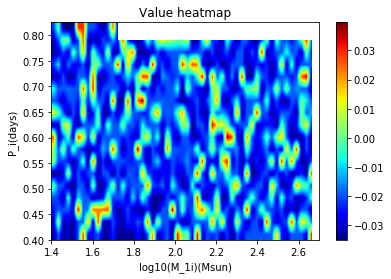

In [67]:
binsize = .025
all_set_grid , all_set_bins, all_set_binloc = griddata(table_object.get_input_data()[all_set][:, 0], table_object.get_input_data()[all_set][:, 1], all_individually, binsize=binsize)

all_set_zmin = all_set_grid[np.where(np.isnan(all_set_grid) == False)].min()
all_set_zmax = all_set_grid[np.where(np.isnan(all_set_grid) == False)].max()

all_set_palette = plt.matplotlib.colors.LinearSegmentedColormap('jet3',plt.cm.datad['jet'],2048)
all_set_palette.set_under(alpha=0.0)

plt.imshow(all_set_grid, extent=(table_object.get_input_data()[all_set][:, 0].min(), table_object.get_input_data()[all_set][:, 0].max(), table_object.get_input_data()[all_set][:, 1].min(), table_object.get_input_data()[all_set][:, 1].max()),
           cmap = all_set_palette, origin = 'lower', vmin = all_set_zmin, vmax = all_set_zmax, aspect='auto', interpolation = 'bilinear')
plt.title("Value heatmap")
plt.xlabel("log10(M_1i)(Msun)")
plt.ylabel("P_i(days)")
plt.colorbar()

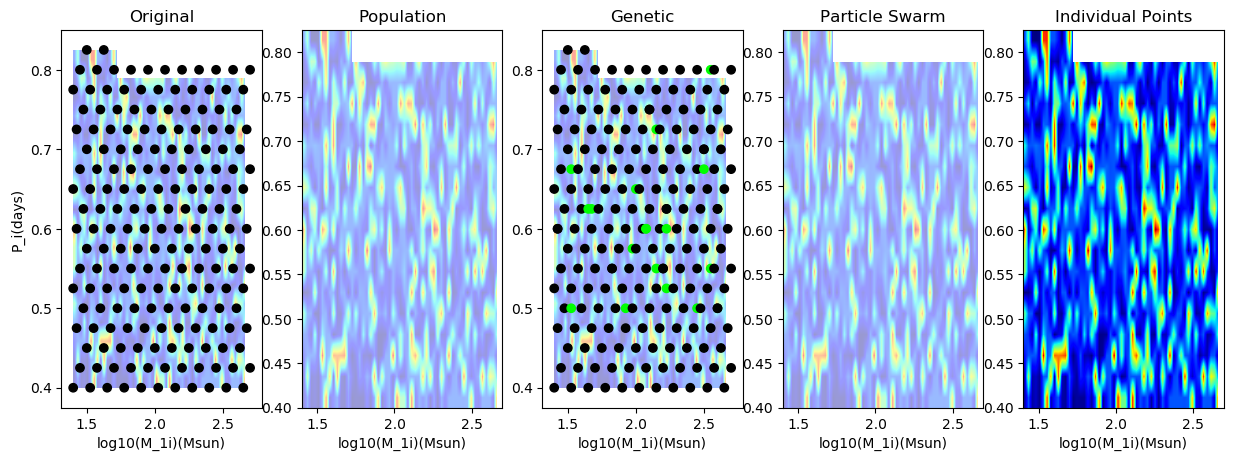

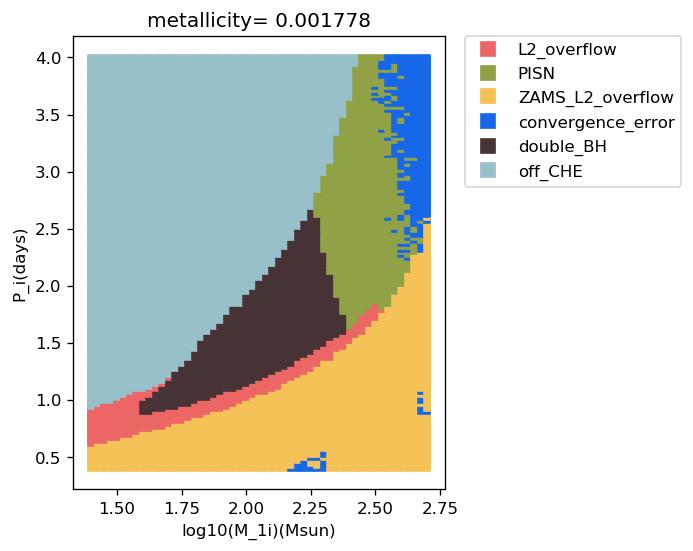

In [74]:
fig, subs = plt.subplots(1, 5, dpi=100, figsize=(15,5))

background_colors = ['#EC6666',
                     '#90A245',
                     '#F5C258',
                     '#1668E8',
                     '#473335',
                     '#98C0CB']

background_colors_dict = {0:background_colors[0],
                          1:background_colors[1],
                          2:background_colors[2],
                          3:background_colors[3],
                          4:background_colors[4],
                          5:background_colors[5] }

#where_to_slice = np.where(table_object.full_data[0] == np.unique(table_object.full_data[0]))


color_dict = {0:"#000000", 1:"#00FF00"}

def color_from_set(s):
    color = []
    for g in s:
        if g in og_set:
            color.append(color_dict[0])
        else:
            color.append(color_dict[1])
    return color

genetic_set = np.sort(np.concatenate((og_set, np.array(genetic_results, dtype=int))))
genetic_color = color_from_set(genetic_set)

colors = {}
colors.update({0: [color_dict[0] for _ in og_set]})
colors.update({1: genetic_color})

subs[0].set_ylabel("P_i(days)")

subs[0].set_title("Original")
subs[1].set_title("Population")
subs[2].set_title("Genetic")
subs[3].set_title("Particle Swarm")
subs[4].set_title("Individual Points")

subs[0].set_xlabel("log10(M_1i)(Msun)")
subs[1].set_xlabel("log10(M_1i)(Msun)")
subs[2].set_xlabel("log10(M_1i)(Msun)")
subs[3].set_xlabel("log10(M_1i)(Msun)")
subs[4].set_xlabel("log10(M_1i)(Msun)")


subs[0].imshow(all_set_grid, alpha = .4, extent=(table_object.get_input_data()[all_set][:, 0].min(), table_object.get_input_data()[all_set][:, 0].max(), table_object.get_input_data()[all_set][:, 1].min(), table_object.get_input_data()[all_set][:, 1].max()),
           cmap = all_set_palette, origin = 'lower', vmin = all_set_zmin, vmax = all_set_zmax, aspect='auto', interpolation = 'bilinear')
subs[1].imshow(all_set_grid, alpha = .4, extent=(table_object.get_input_data()[all_set][:, 0].min(), table_object.get_input_data()[all_set][:, 0].max(), table_object.get_input_data()[all_set][:, 1].min(), table_object.get_input_data()[all_set][:, 1].max()),
           cmap = all_set_palette, origin = 'lower', vmin = all_set_zmin, vmax = all_set_zmax, aspect='auto', interpolation = 'bilinear')
subs[2].imshow(all_set_grid, alpha = .4, extent=(table_object.get_input_data()[all_set][:, 0].min(), table_object.get_input_data()[all_set][:, 0].max(), table_object.get_input_data()[all_set][:, 1].min(), table_object.get_input_data()[all_set][:, 1].max()),
           cmap = all_set_palette, origin = 'lower', vmin = all_set_zmin, vmax = all_set_zmax, aspect='auto', interpolation = 'bilinear')
subs[3].imshow(all_set_grid, alpha = .4, extent=(table_object.get_input_data()[all_set][:, 0].min(), table_object.get_input_data()[all_set][:, 0].max(), table_object.get_input_data()[all_set][:, 1].min(), table_object.get_input_data()[all_set][:, 1].max()),
           cmap = all_set_palette, origin = 'lower', vmin = all_set_zmin, vmax = all_set_zmax, aspect='auto', interpolation = 'bilinear')

subs[0].scatter(table_object.get_input_data()[og_set][:, 0], table_object.get_input_data()[og_set][:, 1], c = colors[0])

subs[2].scatter(table_object.get_input_data()[genetic_set][:, 0], table_object.get_input_data()[genetic_set][:, 1], c = colors[1])
subs[4].imshow(all_set_grid, alpha = 1, extent=(table_object.get_input_data()[all_set][:, 0].min(), table_object.get_input_data()[all_set][:, 0].max(), table_object.get_input_data()[all_set][:, 1].min(), table_object.get_input_data()[all_set][:, 1].max()),
           cmap = all_set_palette, origin = 'lower', vmin = all_set_zmin, vmax = all_set_zmax, aspect='auto', interpolation = 'bilinear')




table_object.plot_class_data()



In [95]:
import importlib
importlib.reload(data)
importlib.reload(classify)
importlib.reload(regress)
importlib.reload(GeneticAlgorithms)
importlib.reload(ParticleSwarm)
print("Reloaded")

Reloaded


In [22]:
#from scipy cookbook

# griddata.py - 2010-07-11 ccampo
import numpy as np

def griddata(x, y, z, binsize=0.01, retbin=True, retloc=True):
    """
    Place unevenly spaced 2D data on a grid by 2D binning (nearest
    neighbor interpolation).
    
    Parameters
    ----------
    x : ndarray (1D)
        The idependent data x-axis of the grid.
    y : ndarray (1D)
        The idependent data y-axis of the grid.
    z : ndarray (1D)
        The dependent data in the form z = f(x,y).
    binsize : scalar, optional
        The full width and height of each bin on the grid.  If each
        bin is a cube, then this is the x and y dimension.  This is
        the step in both directions, x and y. Defaults to 0.01.
    retbin : boolean, optional
        Function returns `bins` variable (see below for description)
        if set to True.  Defaults to True.
    retloc : boolean, optional
        Function returns `wherebins` variable (see below for description)
        if set to True.  Defaults to True.
   
    Returns
    -------
    grid : ndarray (2D)
        The evenly gridded data.  The value of each cell is the median
        value of the contents of the bin.
    bins : ndarray (2D)
        A grid the same shape as `grid`, except the value of each cell
        is the number of points in that bin.  Returns only if
        `retbin` is set to True.
    wherebin : list (2D)
        A 2D list the same shape as `grid` and `bins` where each cell
        contains the indicies of `z` which contain the values stored
        in the particular bin.

    Revisions
    ---------
    2010-07-11  ccampo  Initial version
    """
    # get extrema values.
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # make coordinate arrays.
    xi      = np.arange(xmin, xmax+binsize, binsize)
    yi      = np.arange(ymin, ymax+binsize, binsize)
    xi, yi = np.meshgrid(xi,yi)

    # make the grid.
    grid           = np.zeros(xi.shape, dtype=x.dtype)
    nrow, ncol = grid.shape
    if retbin: bins = np.copy(grid)

    # create list in same shape as grid to store indices
    if retloc:
        wherebin = np.copy(grid)
        wherebin = wherebin.tolist()

    # fill in the grid.
    for row in range(nrow):
        for col in range(ncol):
            xc = xi[row, col]    # x coordinate.
            yc = yi[row, col]    # y coordinate.

            # find the position that xc and yc correspond to.
            posx = np.abs(x - xc)
            posy = np.abs(y - yc)
            ibin = np.logical_and(posx < binsize/2., posy < binsize/2.)
            ind  = np.where(ibin == True)[0]

            # fill the bin.
            bin = z[ibin]
            if retloc: wherebin[row][col] = ind
            if retbin: bins[row, col] = bin.size
            if bin.size != 0:
                binval         = np.median(bin)
                grid[row, col] = binval
            else:
                grid[row, col] = np.nan   # fill empty bins with nans.

    # return the grid
    if retbin:
        if retloc:
            return grid, bins, wherebin
        else:
            return grid, bins
    else:
        if retloc:
            return grid, wherebin
        else:
            return grid